In [119]:
using Pkg
Pkg.activate("rad_transfer"; shared=true)
using RadiativeTransfer
using RadiativeTransfer.CrossSection
using KernelAbstractions
using ..Architectures
using Pkg.Artifacts
using ProgressMeter
using DataStructures
using PyPlot
using CUDA
using Flux
using NetCDF
using NCDatasets
using Dates

include("julia_cs_matrix_helper.jl")
# include("/home/cchristo/proj_christian/RadiativeTransfer.jl/src/CrossSection/types.jl")


 Activating environment at `~/.julia/environments/rad_transfer/Project.toml`
 Activating environment at `~/.julia/environments/rad_transfer/Project.toml`


get_cross_section_matrix (generic function with 1 method)

In [120]:
# reanalysis_file_path = "/export/data2/groupMembers/cchristo/reanalysis_3d/merra2/2015/01/MERRA2_400.tavg3_3d_asm_Nv.20150101.nc4"
# fluo
# ave_reanalysis_file_path = "/export/data2/groupMembers/cchristo/cs_matrices/summit_seasonal/profile_djf_week.nc"

# tofu
ave_reanalysis_file_path = "/net/fluo/data2/groupMembers/cchristo/cs_matrices/summit_seasonal/profile_djf_week.nc"

# all profiles - tofu
profile_ts_file_path = "/net/fluo/data2/groupMembers/cchristo/profiles/summit_merra/summit_all.nc"


"/net/fluo/data2/groupMembers/cchristo/profiles/summit_merra/summit_all.nc"

In [121]:
# open hitran tables
hitran_data_CO2 = read_hitran("hitran_molec_id_2_CO2.tar", mol=2, iso=1, ν_min=400, ν_max=2100)
hitran_data_H2O = read_hitran("hitran_molec_id_1_H2O.tar", mol=1, iso=1, ν_min=400, ν_max=2100)
hitran_data_CH4 = read_hitran("hitran_molec_id_6_CH4.tar", mol=6, iso=1, ν_min=400, ν_max=2100)

# open profile timeseries
ds = Dataset(profile_ts_file_path) ;

In [ ]:
# ds["T"][:,2]
# time_ii
ds["time"][1260]


In [ ]:
for time_i in 1:1 #length(ds["time"])
    display(time_i)
    T = ds["T"][:,time_i]
    P = ds["PL"][:,time_i]
    time_ii = ds["time"][time_i]
    # (lon, lat, z, time)
    var_array_sizes = size(T)
    
    # define grids 
    ν_grid = 400:0.01:2099.99
    p_grid = P[:] / 100
    t_grid = T[:]
    
    # compute cs matrix
    CO2_cs_matrix_cuda = get_cross_section_matrix(hitran_data_CO2, ν_grid, p_grid, t_grid)
    H2O_cs_matrix_cuda = get_cross_section_matrix(hitran_data_H2O, ν_grid, p_grid, t_grid)
    CH4_cs_matrix_cuda = get_cross_section_matrix(hitran_data_CH4, ν_grid, p_grid, t_grid)
    
    # convert to regular array
    CO2_cs_matrix = convert(Array, CO2_cs_matrix_cuda)
    H2O_cs_matrix = convert(Array, H2O_cs_matrix_cuda)
    CH4_cs_matrix = convert(Array, CH4_cs_matrix_cuda)
    
    
#     display(P_prof)
#     plot(p_grid)
    
end

## Open Profile and Extract Profile for a Time

In [49]:
# # ds = ncread(reanalysis_file_path)
# ds = Dataset(ave_reanalysis_file_path)

# # times = ds["time"][:] 
# lats = ds["lat"][:]
# lons = ds["lon"][:]
# T = ds["T"][:]
# P = ds["PL"][:]
# # (lon, lat, z, time)
# var_array_sizes = size(T)

# T_prof = T[:]
# P_prof = P[:] / 100

# OLD

In [122]:
# ncinfo(reanalysis_file_path)
desired_lat = 72.5796
desired_lon = -38.4588

# find index of nearest gridcell
lat_ind = argmin(broadcast(abs, lats .- desired_lat))
lon_ind = argmin(broadcast(abs, lons .- desired_lon))

# set time ind
time_ind = 1

T_prof = T[lat_ind,lon_ind, :,time_ind]
P_prof = P[lat_ind,lon_ind, :,time_ind]

1-element Array{Union{Missing, Float32},1}:
 1.5000001f0

In [123]:
ds = Dataset(ave_reanalysis_file_path)

# times = ds["time"][:] 
lats = ds["lat"][:]
lons = ds["lon"][:]
T = ds["T"][:]
P = ds["PL"][:]
# (lon, lat, z, time)
var_array_sizes = size(T)

T_prof = T[:]
P_prof = P[:] / 100

72-element Array{Float32,1}:
   0.0150000015
   0.026350012
   0.040142514
   0.05679252
   0.077672526
   0.10452404
   0.13959901
   0.18542203
   0.24493755
   0.32178348
   0.4204236
   0.54629266
   0.7059567
   ⋮
 564.1967
 571.8233
 579.432
 587.03296
 594.6333
 602.2248
 609.79553
 617.354
 624.91254
 632.4615
 639.99786
 648.6588

In [5]:
# fetch('H2O_S',1,1,xmin,xmax)
# fetch('CO2_S',2,1,xmin,xmax)
# fetch('CH4_S',6,1,xmin,xmax)

In [124]:
hitran_data_CO2 = read_hitran("hitran_molec_id_2_CO2.tar", mol=2, iso=1, ν_min=400, ν_max=2100)
hitran_data_H2O = read_hitran("hitran_molec_id_1_H2O.tar", mol=1, iso=1, ν_min=400, ν_max=2100)
hitran_data_CH4 = read_hitran("hitran_molec_id_6_CH4.tar", mol=6, iso=1, ν_min=400, ν_max=2100)

HitranTable{Float64}
  mol: Array{Int64}((58893,)) [6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
  iso: Array{Int64}((58893,)) [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  νᵢ: Array{Float64}((58893,)) [400.416314, 400.500621, 400.515163, 400.545478, 400.783489, 400.847081, 400.941244, 401.101872, 401.494615, 401.738456  …  2098.001522, 2098.224403, 2098.558601, 2099.174328, 2099.274806, 2099.389535, 2099.440549, 2099.731408, 2099.87477, 2099.931237]
  Sᵢ: Array{Float64}((58893,)) [2.055e-30, 2.836e-30, 2.834e-30, 3.576e-30, 6.418e-30, 1.242e-30, 2.422e-30, 1.379e-30, 1.891e-30, 1.795e-30  …  8.137e-28, 1.592e-27, 7.599e-29, 9.206e-29, 3.743e-29, 6.561e-29, 5.98e-29, 7.884e-28, 5.626e-28, 2.94e-29]
  Aᵢ: Array{Float64}((58893,)) [1.727e-7, 1.481e-5, 1.568e-6, 1.997e-7, 6.715e-7, 1.102e-8, 2.125e-8, 1.21e-8, 1.572e-6, 0.001561  …  0.04187, 0.04916, 0.003913, 0.004716, 0.001916, 0.003381, 0.003082, 0.04041, 0.04324, 0.001502]
  γ_air: Array{Float64}(

In [77]:
# compute_absorption_cross_section(hitran_data_CO2, Voigt(), 
#                                 collect(ν_grid), p_grid[10], t_grid[10], 
#                                 CEF=HumlicekWeidemann32SDErrorFunction(),
#                                 architecture=Architectures.GPU())

In [15]:
# Architectures.GPU()
# cs_matrix = zeros(Float64,length(p_grid), length(ν_grid)) |> gpu ;
# cs_matrix

In [78]:
# @time compute_absorption_cross_section(hitran_data_H2O, Voigt(), collect(ν_grid), p_grid[10], t_grid[10], 
#     wing_cutoff = 10, architecture=Architectures.CPU())

In [ ]:
@time begin
model_interp = make_interpolation_model(hitran_data_CO2, Voigt(), ν_grid, pressures, temperatures)
    
end

Computing Cross Sections for Interpolation... 20%|█▎    |  ETA: 0:03:14

In [125]:
ν_grid = 400:0.01:2099.99
p_grid = P_prof[:]
t_grid = T_prof[:]

72-element Array{Union{Missing, Float32},1}:
 220.03014f0
 227.4993f0
 231.76367f0
 234.26265f0
 237.09966f0
 241.82622f0
 247.91534f0
 249.90894f0
 248.5147f0
 248.34628f0
 248.3107f0
 248.63264f0
 248.02786f0
   ⋮
 238.94203f0
 239.44572f0
 239.92079f0
 240.35551f0
 240.73962f0
 241.07895f0
 241.34677f0
 241.51242f0
 241.6233f0
 241.26988f0
 241.3036f0
 235.31311f0

In [126]:
# @time begin
# p_test = 600.0
p_test = 1000.0
t_test = 240.0
cs_CO2 = compute_absorption_cross_section(hitran_data_CO2, Voigt(), 
                                collect(ν_grid), p_test, t_test, 
                                CEF=HumlicekWeidemann32SDErrorFunction(),
                                wing_cutoff = 100,
                                architecture=Architectures.GPU())
cs_CO2_2 = compute_absorption_cross_section(hitran_data_CO2, Voigt(), 
                                collect(ν_grid), 100, t_test, 
                                CEF=HumlicekWeidemann32SDErrorFunction(),
                                wing_cutoff = 100,
                                architecture=Architectures.GPU())
cs_CO2_3 = compute_absorption_cross_section(hitran_data_CO2, Voigt(), 
                                collect(ν_grid), 100, t_test, 
                                CEF=HumlicekWeidemann32SDErrorFunction(),
                                wing_cutoff = 100,
                                architecture=Architectures.GPU())

cs_CO2_4 = compute_absorption_cross_section(hitran_data_CO2, Voigt(), 
                                collect(ν_grid), 1000, 140, 
                                CEF=HumlicekWeidemann32SDErrorFunction(),
                                wing_cutoff = 100,
                                architecture=Architectures.GPU())

cs_CO2 = convert(Array, cs_CO2)
cs_CO2_2 = convert(Array, cs_CO2_2)
cs_CO2_3 = convert(Array, cs_CO2_3)
cs_CO2_4 = convert(Array, cs_CO2_4)
# cs_H2O = compute_absorption_cross_section(hitran_data_H2O, Voigt(), 
#                                 collect(ν_grid), p_test, t_test, 
#                                 CEF=HumlicekWeidemann32SDErrorFunction(),
#                                 wing_cutoff = 100,
#                                 architecture=Architectures.CPU())
# cs_CH4 = compute_absorption_cross_section(hitran_data_CH4, Voigt(), 
#                                 collect(ν_grid), p_test, t_test, 
#                                 CEF=HumlicekWeidemann32SDErrorFunction(),
#                                 wing_cutoff = 100,
#                                 architecture=Architectures.CPU())

170000-element Array{Float64,1}:
 2.232131146139638e-34
 2.25748384450956e-34
 2.2802102831402007e-34
 2.2995496047994017e-34
 2.3150021735394533e-34
 2.3264075691024927e-34
 2.3339440580254725e-34
 2.3380431619569187e-34
 2.339244088133836e-34
 2.338033376566591e-34
 2.3347171671031463e-34
 2.329360025335611e-34
 2.321803479854491e-34
 ⋮
 4.2737692977236125e-25
 4.365679089576621e-25
 4.276769338149072e-25
 4.211485173175023e-25
 4.135923248403754e-25
 4.0648808456847415e-25
 4.0003153994448675e-25
 3.9401885238863245e-25
 3.8846607418967723e-25
 3.8336623709787464e-25
 3.715628442439594e-25
 3.6708304531277887e-25

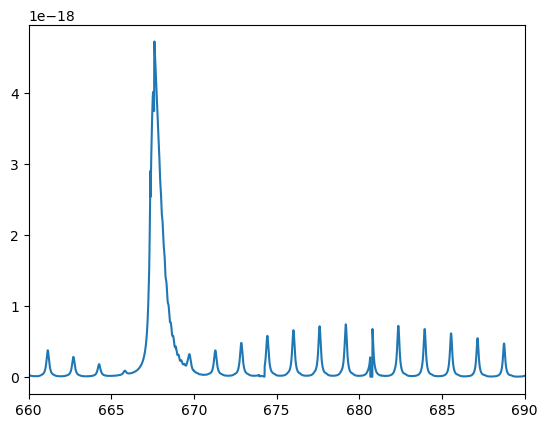

(660, 690)

In [100]:
figure()
# plot(collect(ν_grid), cs_CO2)
plot(collect(ν_grid), cs_CO2)
xlim([660, 690])
# figure()

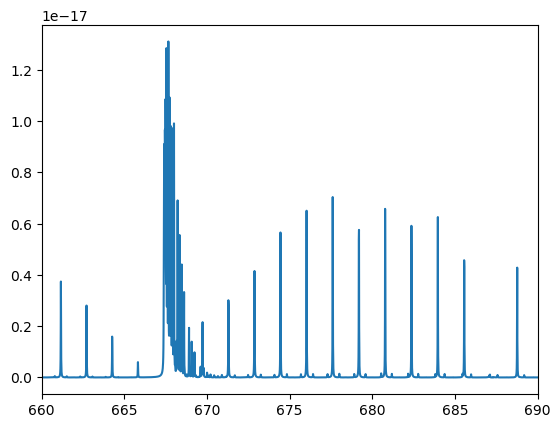

(660, 690)

In [69]:
figure()
# plot(collect(ν_grid), cs_CO2)
plot(collect(ν_grid), cs_CO2_2)
xlim([660, 690])

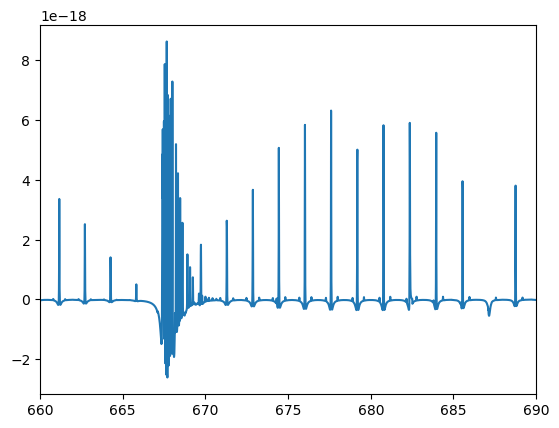

(660, 690)

In [70]:
figure()
# plot(collect(ν_grid), cs_CO2)
plot(collect(ν_grid), cs_CO2_2 - cs_CO2)
xlim([660, 690])

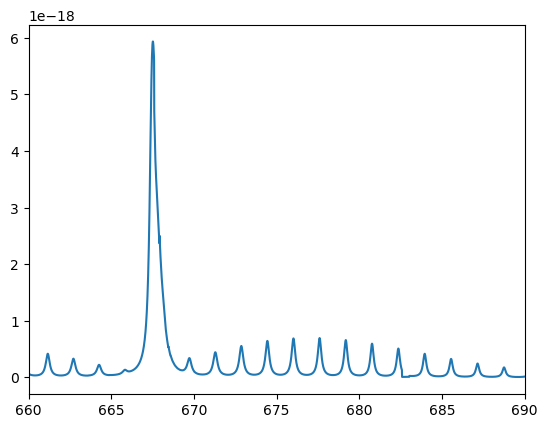

(660, 690)

In [46]:
figure()
# plot(collect(ν_grid), cs_CO2)
plot(collect(ν_grid), cs_CO2_4)
xlim([660, 690])

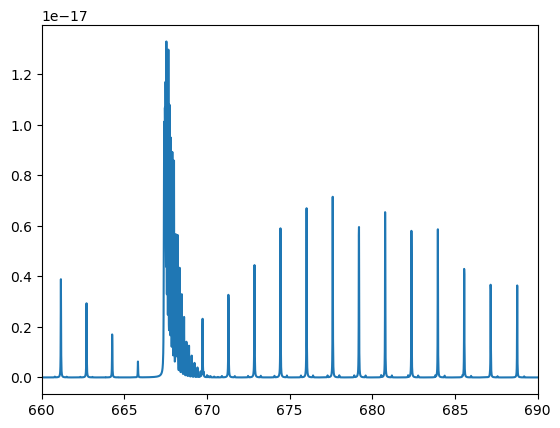

(660, 690)

In [85]:
figure()
# plot(collect(ν_grid), cs_CO2)
plot(collect(ν_grid), cs_CO2_2)
xlim([660, 690])
# figure()
# plot(collect(ν_grid), cs_H2O)
# xlim([650, 700])
# figure()
# plot(collect(ν_grid), cs_CH4)
# xlim([650, 700])

In [127]:
# include("julia_cs_matrix_helper.jl")
CO2_cs_matrix_cuda = get_cross_section_matrix(hitran_data_CO2, ν_grid, p_grid, t_grid)
H2O_cs_matrix_cuda = get_cross_section_matrix(hitran_data_H2O, ν_grid, p_grid, t_grid)
CH4_cs_matrix_cuda = get_cross_section_matrix(hitran_data_CH4, ν_grid, p_grid, t_grid)

Computing Cross Sections for Interpolation...100%|██████| Time: 0:01:08
Computing Cross Sections for Interpolation...100%|██████| Time: 0:00:16
Computing Cross Sections for Interpolation...100%|██████| Time: 0:01:29


72×170000 CuArray{Float32,2}:
 1.36794f-35  1.37257f-35  1.37732f-35  …  2.07865f-34  2.05715f-34
 3.33791f-35  3.34963f-35  3.36169f-35     9.41459f-34  8.5023f-34
 6.07383f-35  6.09562f-35  6.11808f-35     1.84413f-33  1.65212f-33
 9.5063f-35   9.54086f-35  9.57648f-35     3.01912f-33  2.69272f-33
 1.4542f-34   1.45957f-34  1.4651f-34      4.86696f-33  4.31983f-33
 2.34423f-34  2.35311f-34  2.36227f-34  …  8.58305f-33  7.56127f-33
 3.91048f-34  3.9258f-34   3.94163f-34     1.6123f-32   1.4082f-32
 5.5731f-34   5.5952f-34   5.61802f-34     2.38994f-32  2.08204f-32
 7.00891f-34  7.03647f-34  7.06495f-34     2.9241f-32   2.55192f-32
 9.15303f-34  9.18899f-34  9.22614f-34     3.80595f-32  3.32227f-32
 1.19437f-33  1.19906f-33  1.20391f-33  …  4.96285f-32  4.33234f-32
 1.56977f-33  1.57594f-33  1.58232f-33     6.56414f-32  5.72781f-32
 1.98548f-33  1.99326f-33  2.00131f-33     8.20406f-32  7.16445f-32
 ⋮                                      ⋱               
 1.13421f-30  1.13843f-30  1.14

In [128]:
CO2_cs_matrix = convert(Array, CO2_cs_matrix_cuda)
H2O_cs_matrix = convert(Array, H2O_cs_matrix_cuda)
CH4_cs_matrix = convert(Array, CH4_cs_matrix_cuda)

72×170000 Array{Float32,2}:
 1.36794f-35  1.37257f-35  1.37732f-35  …  2.07865f-34  2.05715f-34
 3.33791f-35  3.34963f-35  3.36169f-35     9.41459f-34  8.5023f-34
 6.07383f-35  6.09562f-35  6.11808f-35     1.84413f-33  1.65212f-33
 9.5063f-35   9.54086f-35  9.57648f-35     3.01912f-33  2.69272f-33
 1.4542f-34   1.45957f-34  1.4651f-34      4.86696f-33  4.31983f-33
 2.34423f-34  2.35311f-34  2.36227f-34  …  8.58305f-33  7.56127f-33
 3.91048f-34  3.9258f-34   3.94163f-34     1.6123f-32   1.4082f-32
 5.5731f-34   5.5952f-34   5.61802f-34     2.38994f-32  2.08204f-32
 7.00891f-34  7.03647f-34  7.06495f-34     2.9241f-32   2.55192f-32
 9.15303f-34  9.18899f-34  9.22614f-34     3.80595f-32  3.32227f-32
 1.19437f-33  1.19906f-33  1.20391f-33  …  4.96285f-32  4.33234f-32
 1.56977f-33  1.57594f-33  1.58232f-33     6.56414f-32  5.72781f-32
 1.98548f-33  1.99326f-33  2.00131f-33     8.20406f-32  7.16445f-32
 ⋮                                      ⋱               
 1.13421f-30  1.13843f-30  1.1427

In [183]:
# fname = string(year(time_ii),"/cs_matrix_",year(time_ii), lpad(month(time_ii),2, "0"), lpad(day(time_ii),2,"0"), 
#     "_", lpad(hour(time_ii),2,"0"), lpad(minute(time_ii),2,"0"), ".nc")

# rel_path_name = "/net/fluo/data2/groupMembers/cchristo/cs_matrices/summit/julia_generated/"
# out_file_path = string(rel_path_name, fname)


# out_file_path = 

"/net/fluo/data2/groupMembers/cchristo/cs_matrices/summit/julia_generated/2011/cs_matrix_20110101_0130.nc"

In [10]:
out_file_path = "/net/fluo/data2/groupMembers/cchristo/cs_matrices/summit_seasonal/cs_matrix_djf_week_julia_cpu1.nc"
ds_out = Dataset(out_file_path,"c")

nu_dim = defDim(ds_out,"nu", size(ν_grid)[1])
pres_dim = defDim(ds_out,"pressure", size(p_grid)[1])
# time_dim = defDim(ds_out,"time", 1)



# Define the variables temperature with the attribute units
CO2_cs_matrix_var = defVar(ds_out,"cs_matrix_co2", Float32, ("pressure", "nu"))
H2O_cs_matrix_var = defVar(ds_out, "cs_matrix_h2o", Float32, ("pressure", "nu"))
CH4_cs_matrix_var = defVar(ds_out,"cs_matrix_ch4", Float32, ("pressure", "nu"))
# time_var = defVar(ds_out,"time_ii", Dates.DateTime, ("time",))
# nu_coord = defVar(ds_out,"nu", Float32, ("nu",))
# pres_coord = defVar(ds_out,"pressure", Float32, ("pressure",))
# nu_coord = coord(ds_out,"nu", Float64, ("nu"))

CO2_cs_matrix_var[:,:] = CO2_cs_matrix
H2O_cs_matrix_var[:,:] = H2O_cs_matrix
CH4_cs_matrix_var[:,:] = CH4_cs_matrix
# time_var[:] = time_ii

# nu_coord[:] = collect(ν_grid)
# pres_coord[:] = p_grid


close(ds_out)

closed NetCDF NCDataset

In [6]:
# CO2_cs_matrix_var

In [151]:
# broadcast(max,CO2_cs_matrix)
findmax(CO2_cs_matrix)

(1.2424183217493597e-16, CartesianIndex(1, 26801))

In [152]:
findmin(CO2_cs_matrix)

(0.0, CartesianIndex(2, 1))

In [26]:
findmin(H2O_cs_matrix)

(7.920756f-33, CartesianIndex(1, 59206))

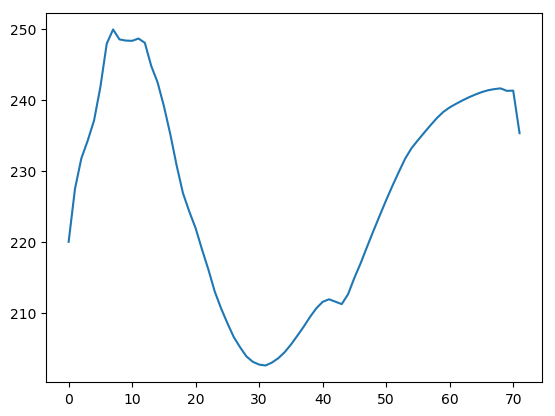

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff23c336908>

In [75]:
# plot(t_grid)
# t_grid
plot(t_grid)

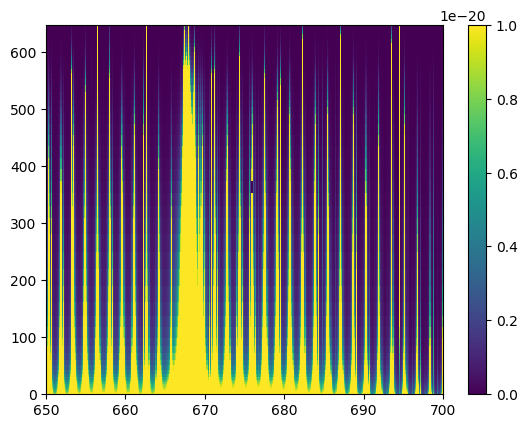

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff1dc0871d0>

In [129]:
pcolormesh(ν_grid, p_grid, CO2_cs_matrix[end:-1:1,:], vmax = 10^-20)
# pcolormesh(CO2_cs_matrix, vmax = 10^-20)
# pcolormesh(cs_CO2, vmax = 10^-20)
xlim([650, 700])

colorbar()

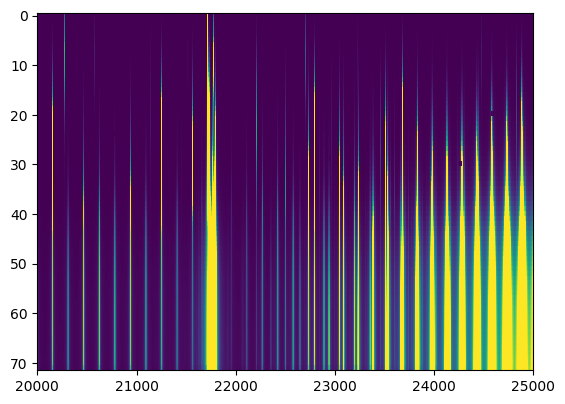

(20000, 25000)

In [111]:
imshow(CO2_cs_matrix, aspect = 50, vmax = 10^-20)
xlim([20000, 25000])

LoadError: syntax: "\" is not a unary operator